In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Libraries
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
# Keras API
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# My data is in google drive.
train_dir ="/content/drive/My Drive/Train"
test_dir="/content/drive/My Drive/Test"

In [ ]:
# function to get count of images
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

In [ ]:
train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
test_samples=get_files(test_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

13 Classes
16291 Train images
694 Test images


In [ ]:
# Pre-processing data with parameters.
train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [ ]:
# set height and width and color of input image.
img_width,img_height =256,256
input_shape=(img_width,img_height,3)
batch_size =32
train_generator =train_datagen.flow_from_directory(train_dir,
                                target_size=(img_width,img_height),                                                    batch_size=batch_size)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(img_width,img_height),                                               batch_size=batch_size)

Found 16291 images belonging to 13 classes.
Found 694 images belonging to 13 classes.


In [ ]:
# The name of the 13 diseases.
train_generator.class_indices

{'Potato___Early_blight': 0,
 'Potato___Late_blight': 1,
 'Potato___healthy': 2,
 'Tomato___Bacterial_spot': 3,
 'Tomato___Early_blight': 4,
 'Tomato___Late_blight': 5,
 'Tomato___Leaf_Mold': 6,
 'Tomato___Septoria_leaf_spot': 7,
 'Tomato___Spider_mites Two-spotted_spider_mite': 8,
 'Tomato___Target_Spot': 9,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 10,
 'Tomato___Tomato_mosaic_virus': 11,
 'Tomato___healthy': 12}

In [ ]:
# CNN building.
model = Sequential()
model.add(Conv2D(32, (5, 5),input_shape=input_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))   
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))          
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 84, 84, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 82, 82, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 41, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 39, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 23104)             0

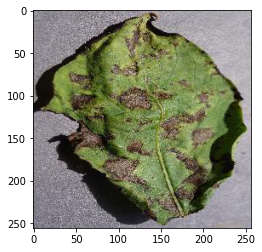

In [ ]:
from keras.preprocessing import image
import numpy as np
img1 = image.load_img('/content/drive/My Drive/Train/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG')
plt.imshow(img1);
#preprocess image
img1 = image.load_img('/content/drive/My Drive/Train/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG', target_size=(256, 256))
img = image.img_to_array(img1)
img = img/255
img = np.expand_dims(img, axis=0)

In [ ]:
from keras.models import Model
conv2d_1_output = Model(inputs=model.input, outputs=model.get_layer('conv2d_1').output)
max_pooling2d_1_output = Model(inputs=model.input,outputs=model.get_layer('max_pooling2d_1').output)
conv2d_2_output=Model(inputs=model.input,outputs=model.get_layer('conv2d_2').output)
max_pooling2d_2_output=Model(inputs=model.input,outputs=model.get_layer('max_pooling2d_2').output)
flatten_output=Model(inputs=model.input,outputs=model.get_layer('flatten').output)
conv2d_1_features = conv2d_1_output.predict(img)
max_pooling2d_1_features = max_pooling2d_1_output.predict(img)
conv2d_2_features = conv2d_2_output.predict(img)
max_pooling2d_2_features = max_pooling2d_2_output.predict(img)
flatten_features = flatten_output.predict(img)

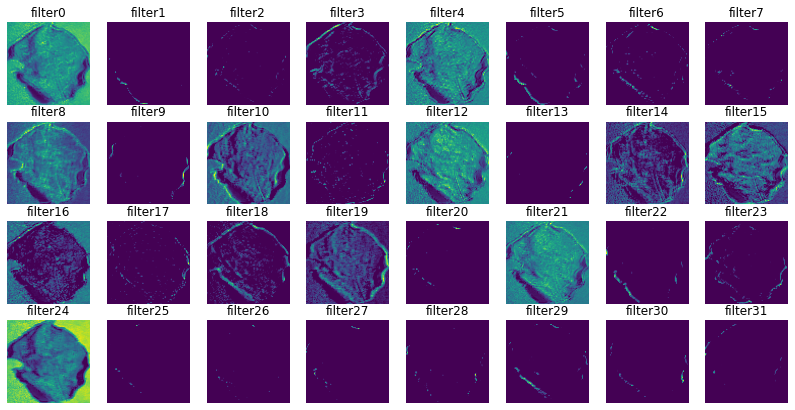

In [ ]:
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_1_features[0, :, :, i], cmap='viridis') # Visualizing in color mode.
plt.show()

In [ ]:
validation_generator = train_datagen.flow_from_directory(
                       train_dir, # same directory as training data
                       target_size=(img_height, img_width),
                       batch_size=batch_size)
opt=keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
train=model.fit_generator(train_generator,epochs=20,                             steps_per_epoch=train_generator.samples//batch_size,                        validation_data=validation_generator,validation_steps=validation_generator.samples // batch_size,verbose=1)

Found 16291 images belonging to 13 classes.
Epoch 1/20
509/509 [==============================] - 3983s 8s/step - loss: 1.0849 - accuracy: 0.6420 - val_loss: 0.6182 - val_accuracy: 0.7871
Epoch 2/20
509/509 [==============================] - 1833s 4s/step - loss: 0.6106 - accuracy: 0.7880 - val_loss: 0.4202 - val_accuracy: 0.8495
Epoch 3/20
509/509 [==============================] - 1853s 4s/step - loss: 0.4765 - accuracy: 0.8354 - val_loss: 0.4116 - val_accuracy: 0.8604
Epoch 4/20
509/509 [==============================] - 1836s 4s/step - loss: 0.3628 - accuracy: 0.8758 - val_loss: 0.2807 - val_accuracy: 0.9035
Epoch 5/20
509/509 [==============================] - 1830s 4s/step - loss: 0.3175 - accuracy: 0.8911 - val_loss: 0.2159 - val_accuracy: 0.9283
Epoch 6/20
509/509 [==============================] - 1827s 4s/step - loss: 0.2710 - accuracy: 0.9082 - val_loss: 0.1493 - val_accuracy: 0.9492
Epoch 7/20
509/509 [==============================] - 1868s 4s/step - loss: 0.2347 - accurac

In [ ]:
# Save model
from keras.models import load_model
model = Sequential()
model.save('/content/drive/MyDrive/project/plant.h5')


ValueError: ignored

In [ ]:
# Loading model and predict.
from keras.models import load_model
model=load_model('/content/drive/MyDrive/project/plant.h5')
# Mention name of the disease into list.
Classes = ["Potato___Early_blight","Potato___Late_blight","Potato___healthy","Tomato___Bacterial_spot","Tomato___Early_blight","Tomato___Late_blight","Tomato___Leaf_Mold","Tomato___Septoria_leaf_spot","Tomato___Spider_mites Two-spotted_spider_mite","Tomato___Target_Spot","Tomato___Tomato_mosaic_virus","Tomato___healthy"]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Pre-Processing test data same as train data.
img_width=256
img_height=256
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
from keras.preprocessing import image
def prepare(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
    
result = model.predict_classes([prepare('/content/drive/My Drive/Test/Tomato___Bacterial_spot/00a7c269-3476-4d25-b744-44d6353cd921___GCREC_Bact.Sp 5807.JPG')])
disease=image.load_img('/content/drive/My Drive/Test/Tomato___Bacterial_spot/00a7c269-3476-4d25-b744-44d6353cd921___GCREC_Bact.Sp 5807.JPG')
plt.imshow(disease)
print (Classes[int(result)])

AttributeError: ignored

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


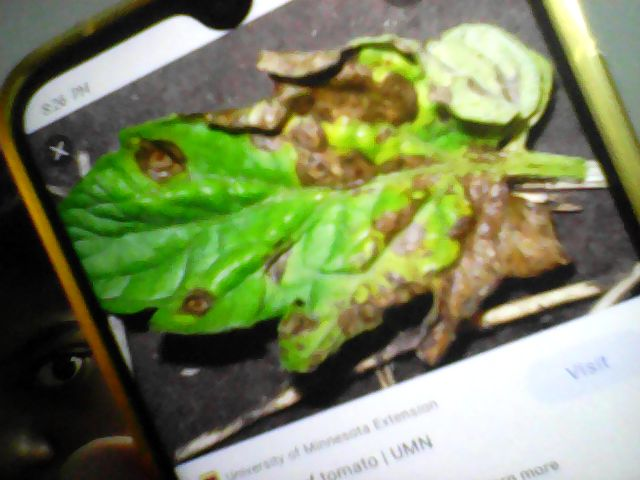

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
from google.colab.patches import cv2_imshow

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5500  100  5500    0     0   141k      0 --:--:-- --:--:-- --:--:--  141k


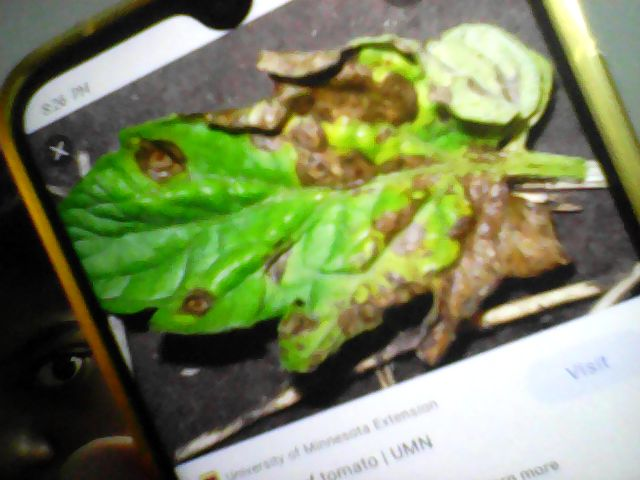

In [ ]:
!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
import cv2
img = cv2.imread('/content/photo.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

Tomato___Early_blight


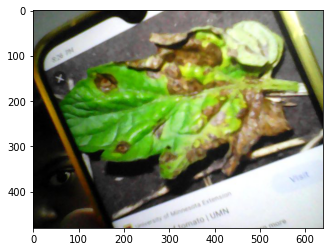

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Pre-Processing test data same as train data.
img_width=256
img_height=256
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
from keras.preprocessing import image
def prepare(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
    
result = model.predict_classes([prepare('/content/photo.jpg')])
disease=image.load_img('/content/photo.jpg')
plt.imshow(disease)
print (Classes[int(result)])

In [ ]:
!pip show tensorflow
!pip install tensorflow==1.14
import tensorflow as tf
from tensorflow.contrib import lite
converter = lite.TFLiteConverter.from_keras_model_file( '/content/drive/My Drive/plant.h5' ) 
model = converter.convert()
file = open( 'output.tflite' , 'wb' ) 
file.write( model )

Name: tensorflow
Version: 1.14.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: protobuf, keras-applications, numpy, gast, keras-preprocessing, grpcio, wheel, tensorboard, tensorflow-estimator, termcolor, wrapt, six, astor, google-pasta, absl-py
Required-by: fancyimpute


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

ImportError: ignored

In [ ]:
!mkdir "tflite_models"